<a href="https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I'm designing an __algorithm that can visually diagnose melanoma, the deadliest form of skin cancer__. In particular, the algorithm will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).  

I also share what I learned from my mistakes!

# Getting Started

This notebook can be run easily on [Google Colab](https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb) with GPU activated: [<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/sebastienlange/dermatologist-ai/blob/master/dermatologist_ai.ipynb)

If you've got any feedback, https://github.com/sebastienlange/dermatologist-ai is the place to leave it. Bug reports, questions, general feedback, and even feature requests are all welcome - just create an [issue](https://github.com/sebastienlange/dermatologist-ai/issues).

Want to give your feedback in private? You can email me on lange.sebastien@gmail.com.

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/skin_disease_classes.png?raw=1)

# Install Prerequisites

In [1]:
# google colab does not come with torch installed.
!pip install -q torch==1.0.0 torchvision

# display live plots while training (loss, accuracy, ROC AUC...)
!pip install -q livelossplot==0.3.3

# in case of error: module 'PIL.Image' has no attribute 'register_extensions'
# execute command below to reinstall pillow, then restart the environment
#!pip install -q --no-cache-dir -I pillow

    100% |████████████████████████████████| 591.8MB 25kB/s 
fastai 1.0.48 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


# Download Data

In [0]:
import pandas as pd
import numpy as np
import os

phases = ['train', 'valid', 'test']
data_root = os.path.join(os.getcwd(), 'data')
data_dir = {phase:os.path.join(data_root, phase) for phase in phases}

In [3]:
# download train.zip, valid.zip, test.zip
for phase in phases:
  url = f'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip'
  !wget -nc $url -P $data_root

--2019-03-16 18:47:57--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.235.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.235.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘/content/data/train.zip’

train.zip           100%[===================>]   5.34G  72.9MB/s    in 76s     

2019-03-16 18:49:13 (71.6 MB/s) - ‘/content/data/train.zip’ saved [5736557430/5736557430]

--2019-03-16 18:49:14--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.29
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864538487 (824M) [application/zip]
Saving to: ‘/content/data/val

In [0]:
import zipfile

from tqdm import tqdm_notebook as tqdm

In [5]:
# unzip train.zip, valid.zip, test.zip
for phase in phases:
  if not os.path.exists(data_dir[phase]):
    with zipfile.ZipFile(os.path.join(data_root, f'{phase}.zip'), 'r') as myzip:
      for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
        myzip.extract(member=file, path=data_root)

# Explore Data

In [6]:
import glob

classes = [path.split(os.path.sep)[-1] for path in sorted(glob.glob(os.path.join(data_root, 'train', '*')))]
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

These are our 3 classes! Let's now explore how much data we have and how it's distributed:

In [0]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def print_images_distribution(plot=False):

  image_repartition = pd.DataFrame(index=[d.split(os.path.sep)[-1] for d in data_dir.values()], columns=classes)
  plot_data = pd.DataFrame(columns=['Class', 'Phase', 'Count'])
  
  for phase in [d.split(os.path.sep)[-1] for d in data_dir.values()]:
    for disease in classes:
      count =  len(glob.glob(os.path.join(data_root, phase, disease, '*.jpg')))
      image_repartition.loc[phase][disease] = count
      plot_data = plot_data.append({'Class': disease, 'Phase': phase, 'Count': count}, ignore_index=True)

  image_repartition.loc['TOTAL'] = image_repartition.sum(axis=0)          
  image_repartition['TOTAL'] = image_repartition.sum(axis=1)
  image_repartition['Ratio'] = np.round(image_repartition.TOTAL / (image_repartition.TOTAL.sum() - image_repartition.TOTAL[-1]), 2)
  
  if plot:
    sns.set_style("whitegrid")
    sns.barplot(x='Class', y='Count', hue='Phase', data=plot_data, palette='Blues')

  return image_repartition

,melanoma,nevus,seborrheic_keratosis,TOTAL,Ratio
train,374,1372,254,2000.0,0.73
valid,30,78,42,150.0,0.05
test,117,393,90,600.0,0.22
TOTAL,521,1843,386,2750.0,1.00


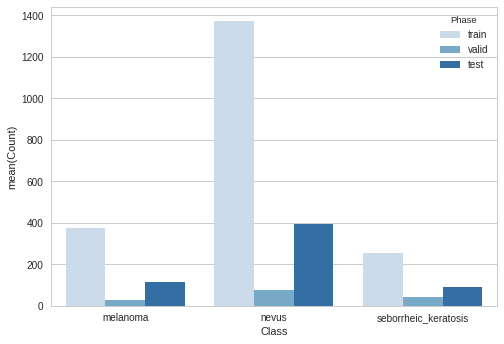

In [8]:
print_images_distribution(True)

## Class imbalance
We have a __class imbalance problem__ in this dataset: __nevus is much more represented__ whereas we are interested to have a great accuracy in the prediction of melanoma and seborrheic_keratosis.  

Without any change, the model would just learn to predict nevus. (My first mistake 😉)

## Download more data

Fortunately, we can __download more samples__ from [ISIC Archive](https://www.isic-archive.com/#!/onlyHeaderTop/gallery).  

So let's download more samples and ensure we don't have any duplicate!


In [0]:
data_dir['more'] = os.path.join(data_root, 'more')

The additional data is stored publicly on my personal Google Drive.

In [0]:
google_drive_download_link = 'https://drive.google.com/uc?export=download'

files_available_for_download = {
                                # additional images downloaded from https://www.isic-archive.com/#!/onlyHeaderTop/gallery
                                'melanoma-1.zip': '10Wo3RwSC-O4YEAZkU77ZehciDpWCn3Si',
                                'melanoma-2.zip': '1L9XLBX1sIYX9GiEdfhWizeOuP52Pdgm2',
                                'melanoma-3.zip': '1jP7YCh5e2g588f0j5ikURsU7oNCLtQCL',
                                'melanoma-4.zip': '1_IjF2lZZE2yeaZSE9rXqrfrgXd_UdKZi',
                                'melanoma-5.zip': '1KRF0zRWU-yGSa87p04kQvCHvTiCnZnOO',
                                'melanoma-6.zip': '1vL18GGPxNCY--R-VLoFRqxeI2ZiSfTJi',
                                'melanoma-7.zip': '1bFoqLrcUu1YwYq5EQxMrg7WQjRRHNA8U',
                                'melanoma-8.zip': '1tFW8OkvpWyXpm0ueeCld0qG5k6uk7q3X',
                                'nevus.zip': '1GqBasxjZJNh_C8B4uWaxGLbvDU3HE0e3',
                                'nevus-2.zip': '1H7PDGPnCapqwmYY2FYaSp1ppqMg9W72a',
                                'seborrheic_keratosis.zip': '1wTgY_AFo0wLF-0g-2mxzkwAv2EXmpGq1',
    
                                # my own pretrained models               
                                'DenseNet.pt': '1c83tG5-fvTQsRB-N-ADLXwG7_W3mbiwr',
                                'Inception3.pt': '17NFK86u9V1sbc-048CzsBSzGwsLSdrqT',  
                                'NASNetALarge.pt': '1IwbIm8OJygcP9M51QspH3BKqJ9otuInW',
                               }

Google requires a confirmation because it can not perform virus scan on big files. So the download_file function below is a little bit tricky because I need to get the confirm value.  
Otherwise files should be downloaded manually.

In [0]:
import html

# download files on google drive and bypass virus scan confirm if any
def download_file(fn):
  
  if not os.path.exists(fn) and not os.path.exists(os.path.join(google_drive_shared_path, fn.split(os.path.sep)[-1])):
    path = os.path.dirname(fn)
    print(f'Downloading {os.path.basename(fn)} with id {files_available_for_download[os.path.basename(fn)]} to path {path}')
    url = f'"{google_drive_download_link}&id={files_available_for_download[os.path.basename(fn)]}"'
    temp_cookie = 'gdown.cookie.temp'
    !wget --progress=dot:giga --no-check-certificate --load-cookie $temp_cookie --save-cookie $temp_cookie $url -O $fn
    
    confirm = None
    confirm_word = '&confirm='
    id_word = '&id='
    confirm_word_escaped = html.escape(confirm_word)
    id_word_escaped = html.escape(id_word)
    
    while os.path.getsize(fn) < 100000:
      for i, line in enumerate(open(fn)):
        if i<5 and confirm_word_escaped in line: 
          # it's not the expected file but a redirection to confirm download
          start_idx = line.find(confirm_word_escaped) + len(confirm_word_escaped)
          end_idx = line.find(id_word_escaped, start_idx)
          
          # get confirm value
          confirm=line[start_idx:end_idx]
        
      if confirm is not None:
        print('Google requires no virus scan confirm...')
        url = url.replace(id_word, f'{confirm_word}{confirm}{id_word}')
        !wget --progress=dot:giga --no-check-certificate --load-cookie $temp_cookie --save-cookie $temp_cookie $url -O $fn
    
    !rm -r $temp_cookie

I personnally mounted my own Google Drive for easiness and skip slow download.

In [0]:
google_drive_mount_path = '/content/gdrive'
google_drive_shared_path = os.path.join(google_drive_mount_path, 'My Drive' , 'dermatologist-ai')

def mount_google_drive():
  
  from google.colab import drive
  drive.mount(google_drive_mount_path)
  
#mount_google_drive()

In [13]:
# download all zip files containing more images, if google drive not mounted
for fn in files_available_for_download.keys():
  if os.path.splitext(fn)[1]=='.zip':
    download_file(os.path.join(data_root, fn))

Cannot open cookies file ‘gdown.cookie.temp’: No such file or directory
--2019-03-16 18:54:04--  https://drive.google.com/uc?export=download&id=10Wo3RwSC-O4YEAZkU77ZehciDpWCn3Si
Resolving drive.google.com (drive.google.com)... 173.194.74.102, 173.194.74.101, 173.194.74.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.74.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/data/melanoma-1.zip’

     0K                                     21.2M=0s

2019-03-16 18:54:05 (21.2 MB/s) - ‘/content/data/melanoma-1.zip’ saved [3251]

Google requires no virus scan confirm...
--2019-03-16 18:54:06--  https://drive.google.com/uc?export=download&confirm=OLOC&id=10Wo3RwSC-O4YEAZkU77ZehciDpWCn3Si
Resolving drive.google.com (drive.google.com)... 173.194.74.101, 173.194.74.139, 173.194.74.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.74.101|:443... connected.
HTTP request sent, awaiting response.

In [0]:
def get_unique_images(myzip):
  # prevent having any duplicate accross train, valid and test!!!
  
  for image_file in myzip.namelist():
    duplicate = False
    for d in data_dir.values():
      if os.path.exists(f'{d}/{disease}/{image_file}'):
        duplicate = True
    if not duplicate:
      yield image_file

In [15]:
# extract images from zip files
for disease in classes:
  for root_path in [data_root, google_drive_shared_path]:
    for fn in sorted(glob.glob(f'{root_path}/{disease}*.zip')):
      with zipfile.ZipFile(fn, 'r') as myzip:
        members = list(get_unique_images(myzip))
        print(f'Extracting {len(members)} images from {fn.split(os.path.sep)[-1]} and ignoring {len(myzip.namelist())-len(members)} duplicates')

        for file in tqdm(members):
          myzip.extract(member=file, path=os.path.join(data_dir['more'], disease))

Extracting 300 images from melanoma-1.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-2.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-3.zip and ignoring 0 duplicates



Extracting 100 images from melanoma-4.zip and ignoring 0 duplicates



Extracting 96 images from melanoma-5.zip and ignoring 0 duplicates



Extracting 238 images from melanoma-6.zip and ignoring 0 duplicates



Extracting 64 images from melanoma-7.zip and ignoring 129 duplicates



Extracting 85 images from melanoma-8.zip and ignoring 0 duplicates



Extracting 300 images from nevus-2.zip and ignoring 0 duplicates



Extracting 300 images from nevus.zip and ignoring 0 duplicates



Extracting 32 images from seborrheic_keratosis.zip and ignoring 0 duplicates


In [16]:
print_images_distribution()

,melanoma,nevus,seborrheic_keratosis,TOTAL,Ratio
train,374,1372,254,2000.0,0.41
valid,30,78,42,150.0,0.03
test,117,393,90,600.0,0.12
more,1483,600,32,2115.0,0.43
TOTAL,2004,2443,418,4865.0,1.00


## Oversampling

We now have enough melanoma samples.  
But __still not enough seborrheic keratosis__. So I choose the __oversampling approach__ for this unbalanced class and I increase the number of observations which are just copies of existing samples.  

At each epoch, for a given phase, I duplicate image indexes randomly until I have as many samples in each class.

In [0]:
def balance_indices(epoch_indices, y):
  # it uses oversampling to increase the size of imbalanced classes by randomly selecting more samples 
  
  images_per_class = {i:[] for i in range(len(classes))}
          
  for i in epoch_indices:
    images_per_class[y[i]].append(i)
  
  counts = [len(indexes) for indexes in images_per_class.values()] 
  max_samples_per_class = np.max(counts)
  
  for i in range(len(classes)):  
    for j in range(max_samples_per_class-len(images_per_class[i])):
      over_sampled_i = np.random.randint(0, counts[i])
      images_per_class[i].append(images_per_class[i][over_sampled_i])
      
  return sorted([item for sublist in images_per_class.values() for item in sublist])

## Too small validation set
In addition, the initial validation set is very small (150 samples) and will not be a good predictor of model performance. (My second mistake 😉)  

So I __change the partition to have 80% in training (3412 samples) an 20% in validation (853)__.  

I of course keep the test set imbalanced for the challenge purpose.

# Data Augmentation

As there are "only" 4265 images in the training set, one way to enlarge the dataset is to "augmentate" the images by applying different chained transformations.   

I create two chained transformations:
 - one for validation and test with image resized to 133% of 224 (or 299, or 331) and center croped to 224x224 (or 299 for Inception v3, or 331 for NasNetALarge), to have some __zoom effect__, and then normalized;
 - one for training with some data augmentation: 
     - __random image rotation__ with a maximum of 30 degrees, 
     - __random resized crop__ to the same size as above, with a 0.70-1.00 scale, 
     - __random translation__ with a maximum absolute fraction of 20%, 
     - __random zoom__ with a 0.8-1.2 scale,
     - __random Gaussian noise__ from [imgaug](https://github.com/aleju/imgaug),
     - __random horizontal/vertical flip__.
     - __random color jitter__,
     - and __random Gaussian blur__ from [imgaug](https://github.com/aleju/imgaug),
 
These transformations will also __reduce overfitting to the training set__. 

Color jitter and particularly Gaussian blur were not present in all of my runs because it makes learning much slower, while it doesn't seem to reduce overfitting as much as I would like.

The ImgAugTransform class below is a wrapper around [imgaug](https://github.com/aleju/imgaug) to make it compatible with [PyTorch transforms](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [0]:
import imgaug as ia

from imgaug import augmenters as iaa

# wrapper around imgaug compatible with pytorch transforms
class ImgAugTransform:
  def __init__(self, aug):
    self.aug = aug
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(np.uint8(self.aug.augment_image(img)))
  
  def __repr__(self):
    return self.__class__.__name__ + ' ' + str(self.aug)

I noticed that dermascopic images sometimes include hairs, or some kind of colored patch, or a ruler.  
 
So in one of my last runs, I quickly created and added __my own augmenter to draw random fake hairs__:

In [0]:
from PIL import Image, ImageDraw

# draw random lines for fake hairs
class DrawHair:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    for i in range(np.random.randint(5,20)):
        draw.line((np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1]),
                   np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1])), fill=0, width=np.random.randint(1,7))
    del draw

    return img

And my own augmenter to draw __random fake colored elliptic or rectangular patch__:

In [0]:
# draw random colored rectangles or ellipse for fake "patches"
class DrawShape:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    corner = np.random.randint(1,5)
    coord = ((np.random.randint(0,img.size[0]/8) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/8 + img.size[0]/2* (corner==3 or corner==4))), 
                    (np.random.randint(0,img.size[0]/2) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/2 + img.size[0]/2* (corner==3 or corner==4))))
    if np.random.rand()<0.5:
        draw.ellipse(coord, fill=np.random.randint(0,240))
    else:
        draw.rectangle(coord, fill=np.random.randint(0,240))

    del draw

    return img

Not all models require the same input image size. Here are the ones I needed:

In [0]:
def get_image_size(model_name):
  
  model_name = model_name.lower()
  
  if 'inception' in model_name or 'xception' in model_name:
    return 299
  elif 'nasnetalarge' in model_name:
    return 331
  else:
    return 224


So here are my transorms:

In [0]:
import torchvision.transforms as transforms

# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224 (299 for inception)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def get_transform(model_name, phase, resize=0.75):

  image_size = get_image_size(model_name)

  if phase=='train':
    return transforms.Compose([
                                transforms.RandomResizedCrop(image_size, scale=(0.7,1)),
                                transforms.RandomApply([DrawHair()], p=0.25),
                                transforms.RandomApply([DrawShape()], p=0.25),
                                transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
                                ImgAugTransform(iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15*255), per_channel=0.5, name='GaussianNoise'))),
                                ImgAugTransform(iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 1.0), name='GaussianBlur'))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), name='Sharpen'))),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                normalize])
  else:
    return transforms.Compose([
                                transforms.Resize(int(image_size/resize)),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                normalize])

## Image preprocessing

A lot of images are very big (5-20 MB, width/height of 4000-6000 pixels).  

Loading and resizing them takes around 90% of the time of each epoch!  
Let's create copies with a smaller size still compatible with our transforms and some models requiring varying input size, so that __the duration of each epoch is reduced by 90%__!

I would have saved a lot of time if I realized it earlier 😉 (My third mistake)

In [0]:
for dir_name, path in data_dir.items():
  for fn in tqdm(sorted(glob.glob(os.path.join(path, '*', '*.jpg'))), desc=('Resize ' + path.split(os.path.sep)[-1])):
    resized_fn = fn.replace(dir_name, dir_name + '_resized')
    if not os.path.exists(resized_fn):
      if not os.path.exists(os.path.dirname(resized_fn)): 
        os.makedirs(os.path.dirname(resized_fn))
      try:
        im = Image.open(fn)
        # double size required by largest tested model (NASNetALarge)
        size = 331*2, 331*2
        if im.size != size:
          im_resized = im.resize(size, Image.ANTIALIAS)
          im_resized.save(resized_fn)
      except OSError as e:
        print("error " + str(e))

# Load Data

Three different data loaders are initialized for the three different sets of images: training, validation, and test.  
For each iteration, each data loader will return a batch with multiple images and perform one step of forward and back propagation.

In [0]:
import torch

from torchvision import datasets
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = {phase: 32 if phase=='train' else 16 for phase in phases}

image_folders = {phase: datasets.ImageFolder(data_dir[phase] + '_resized', transform=get_transform('densenet', phase)) for phase in phases}

loaders = {phase: torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size[phase], num_workers=num_workers, shuffle=(phase=='train')) for phase in phases}

## Batch samples with and without data augmentation
Let's show a single batch from the __train set with data augmentation__:

In [0]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def show_batch(phase):
  dataiter = iter(loaders[phase])
  images, labels = dataiter.next()
  imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))
  
show_batch('train')

And a single batch from the __test set with NO data augmentation__:

In [0]:
show_batch('test')

# Create a Model

Let's first detect if we have a GPU available:

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Having satisfactory performance with a model created from scratch would take days or weeks to train... and still you have to train multiples architectures and pick the best one.  

__Transfer Learning__ is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.
There are a some pre-trained Machine Learning models out there that became quite popular. One of them is the [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf) model, which was trained for the ImageNet “Large Visual Recognition Challenge”. In this challenge, participants had to classify images into 1000 classes, like “Zebra”, “Dalmatian”, and “Dishwasher”.

Despite the objects it was trained to classify are quite different compared to skin diseases images, the features detection part of such pretrained model are often reused to classify completely different images.  

I initially selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to reuse because it has (had) __improved performance over others on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has a lot of layers, the time to train a single epoch is very similar to simpler pretrained models.

Picture below shows the smaller DenseNet-121.

![title](https://cdn-images-1.medium.com/max/1000/1*BJM5Ht9D5HcP5CFpu8bn7g.png?raw=1)

We just need two modifications to the pretrained model (see configure_model function below):
 - as skin diseases images are still different compared to cats, dogs, cars... I __freeze the parameters of the two first blocks, and I train the parameters of the two last blocks__ (Dense Block 3 and Dense Block 4). __This step is crucial!__ Otherwise the model caps at 80% accuracy in train set, and swings between 50-60% in test set. (My fourth mistake 😉)
 - and then __replace the last fully connected layer (the classifier itself) so that it outputs 3 classes__ instead of 1000.

I tried two different final classifiers and retained the first one:
- one layer with a single Linear classifier;
- two layers, with batch normalization to prevent vanishing gradients and dropout for regularization.  

Both outputs raw scores that will later be transformed as probabilities using softmax.

In [0]:
import torchvision.models as models
import torch.nn as nn

def set_parameter_requires_grad(parameters, feature_extract):
  # set parameters that should be trained
  
  for param in parameters:
      param.requires_grad = not feature_extract

def configure_model(model, final_classifier, num_classes, feature_extract, skip_requires_grad = False):
  
  if not skip_requires_grad:
    set_parameter_requires_grad(model.parameters(), feature_extract)
    
  return nn.Linear(final_classifier.in_features, num_classes)

The initialize_model function below allows you to create and configure a few well-known models:

In [0]:
def initialize_model(model_name, num_classes, use_pretrained=True, feature_extract=True):
  
    model = None

    if model_name == "resnet":
        """ Resnet152
        """
        model = models.resnet152(pretrained=use_pretrained)
        model.fc = configure_model(model, model.fc, num_classes, feature_extract)

    elif model_name == "alexnet":
        """ Alexnet
        """
        model = models.alexnet(pretrained=use_pretrained)
        model.classifier[6] = configure_model(model, model.classifier[6], num_classes, feature_extract)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        model.classifier[6] = configure_model(model, model.classifier[6], num_classes, feature_extract)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model.parameters(), feature_extract)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model = models.densenet161(pretrained=use_pretrained)
        model.classifier = configure_model(model, model.classifier, num_classes, feature_extract)

    elif model_name == "inception3":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model = models.inception_v3(pretrained=use_pretrained)
        # Handle the auxilary net
        model.AuxLogits.fc = configure_model(model, model.AuxLogits.fc, num_classes, feature_extract)
        # Handle the primary net
        model.fc = configure_model(model, model.fc, num_classes, feature_extract, skip_requires_grad=True)
        
    elif model_name == 'xception' or model_name == 'nasnetalarge':
        """ Xception
        Be careful, Xception and NasNetALarge expect (299,299) and (331,331) sized images respectively
        """
        !pip install -q --upgrade pretrainedmodels
        import pretrainedmodels
        
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        model.last_linear = configure_model(model, model.last_linear, num_classes, feature_extract)

    else:
        print(f"Invalid model name: {model_name}, exiting...")
        exit()

    # Send the model to GPU if any
    return model.to(device), get_image_size(model_name)

In [0]:
import itertools

model, image_size = initialize_model('densenet', len(classes), use_pretrained=True)

# Freeze denseblock1 and denseblock2
# Train  denseblock3 and denseblock4
set_parameter_requires_grad(itertools.chain(model.features.denseblock3.parameters(), 
                                            model.features.denseblock4.parameters()), feature_extract=False)

## Loss function

__CrossEntropyLoss__ is the appropriate loss function for a classification model that outputs raw scores for each class.  

__Melanoma is the deadliest form of cancer__. Despite my samples will correctly be balanced at each iteration, I want to __penalize by 50% the loss on melanoma__.

In [0]:
#rescaling weight given to each class
weight = [1.5, 1, 1]
criterion = nn.CrossEntropyLoss(torch.Tensor(weight).to(device))

## Optimizer

Whatever the optimizer, he needs to know which parameters of the model he should optimize. If we are finetuning we will be updating all parameters. However, if we are doing feature extract method, we will only update the parameters that we have just initialized, i.e. the parameters with requires_grad is True.

In [0]:
def get_params_to_optimize(model):
  # Gather the parameters to be optimized/updated in this run. 
  params_to_update = {}
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update[name] = param
  
  return params_to_update

I selected __Adam optimizer__ because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

In [0]:
import torch.optim as optim

optimizer = optim.Adam(get_params_to_optimize(model).values(), lr=0.001, weight_decay=1e-6)

## Choosing the right metric 
What is the single metric to take into account to determine if the model is good?

For classification problems, the following metrics are often usefull:
- Precision-Recall
- ROC-AUC
- Accuracy
- Log-loss

In this challenge, the decision is easy because the performance is measured against the __mean ROC-AUC of melanoma and seborrheic keratosis__.

In [0]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(y_true, y_pred, plot=False):
    """
    return ROC AUC Score for melanoma, seborrheic_keratosis, and their mean
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    if plot:
      plt.figure()
      colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        if plot:
          # plot ROC curve
          plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                   label='ROC curve for task {d} - class {c} (area = {f:.3f})'.format(d=i+1, c=('melanoma' if i==0 else 'seborrheic_keratosis'), f=roc_auc[i]))
          
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    if plot:
      # format figure
      plt.plot([0, 1], [0, 1], 'k--', lw=2)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curves')
      plt.legend(loc="lower right")
      ax = plt.gca()
      ax.set_facecolor('white')
      plt.show()

      # print scores
      for i in range(3):
          print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))
        
    return roc_auc

Have we achieved a higher ROC AUC metric in the validation set? Let's save it!

In [0]:
import copy

def save_model(save_path, model, best_epoch_auc):
  # we achieved a higher ROC AUC metric in validation set!
  # let's save it
  
  if save_path is not None:
    logging.info('=> Saving model')
    torch.save(model.state_dict(), save_path.replace('.', f'_{best_epoch_auc:.4f}.'))
  
  best_model_wts = copy.deepcopy(model.state_dict())                    
  
  return best_model_wts, best_epoch_auc

# Train the Model

## Helper functions

### Logging
I want to log some information before, after and while training. Here is what I needed:

In [0]:
def get_model_path(model_name, extension):
  # return a unique name for logging and saving model
  
  i = 1
  while len(glob.glob(f'{model_name}_{i}*.{extension}')):
    i+=1
  return f'{model_name}_{i}.{extension}'

In [0]:
import logging

def init_log(model_name):
  
  # reset handlers
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  # log to file
  save_path = get_model_path(model_name, 'pt')
  fileHandler = logging.FileHandler(save_path.replace('.pt', '.log'))
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  # log to console
  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)
  
  return save_path

In [0]:
from collections import Counter
  
def log_model_summary(model_name, criterion, optimizer, train_transform, valid_transform, phase_data_dirs, params_to_train, over_sampling, cv, test_indices, start=True, time_elapsed=0):
  
  first_word = 'Start' if start else 'End'
  logging.info(f'{first_word} training {model_name} model')
  
  if not start:
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  
  y = get_true_labels(phase_data_dirs['train'])
  counter = Counter(y)
  logging.info(f'  Class distribution ({np.sum(list(counter.values()))}): ' + ', '.join(f'{count} ' + classes[int(disease)] for disease, count in counter.items()))
  logging.info(f'  Oversampling: {over_sampling}')
  logging.info(f'  Cross validation: {cv}')
  logging.info(f'  Leaving {len(test_indices)} samples for untrained validation')
  
  logging.info(f'  Loss function: {criterion} - Weights: {criterion.weight}')
  logging.info(f'  Optimizer: {optimizer}')
  
  logging.info(f'  {len(params_to_train)} parameters to train:')
  if len(params_to_train) > 10:
    params_to_train = params_to_train[0:5] + ['...'] + params_to_train[::-1][0:5][::-1]
  for name in params_to_train:
    logging.info(f'    {name}')
    
  logging.info(f'  Train tranforms: {train_transform}')
  logging.info(f'  Valid tranforms: {valid_transform}')
  logging.info('')

### Live plotting
_"Don't train deep learning models blindfolded! Be impatient and look at each epoch of your training!"_  

I forked [LiveLossPlot](https://github.com/sebastienlange/livelossplot) to enhance it and [add support for custom series](https://github.com/stared/livelossplot/pull/46) and [add support for marker on higher/lower scores](https://github.com/stared/livelossplot/pull/48).

While ROC AUC is the choosen metric, I also plot after each epoch log-loss and accuracy.

In [0]:
def update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc):
  ## update data for LiveLossPlot
  
  logs[f'{phase}_log loss'] = epoch_loss
  logs[f'{phase}_accuracy'] = epoch_acc
  logs[f'{phase}_ROC AUC'] = epoch_auc[2]
  
  return logs

I also display on the progress bar log-loss, accuracy and even per-class accuracy after each batch... That's very addictive 😃

In [0]:
def get_running_status(phase, running_loss, running_corrects, items_processed):
  # update progress bar with current loss and accuracy
  # and even pre-class accuracy
  
  progresses = []
  progresses.append(f'{phase}_loss={running_loss/sum(items_processed.values()):.3f}')
  progresses.append(f'{phase}_acc={sum(running_corrects.values())/sum(items_processed.values()):.3f}')
  
  for disease in classes:
    progresses.append(f'{disease[0:5]}_acc={running_corrects[disease]/items_processed[disease]:.3f}')

  return ', '.join(progresses)

### Computing stats
The final classifier output raw scores.  

To compute ROC AUC score, I need probabilities calculated with and one-hot encoded true labels:

In [0]:
def compute_stats(inputs, labels, outputs, y_true, y_prob):
  # for a given batch it computes the y_true (one hot encoding)
  # and the probabilities for each class
  
  y_true = np.append(y_true, one_hot_encoding(labels.data.cpu().numpy()), axis=0)

  probs = torch.nn.Softmax(dim=1)(outputs.data).cpu().numpy()
  y_prob = np.append(y_prob, probs, axis=0)
  
  return y_true, y_prob, probs

In [0]:
def one_hot_encoding(data):
  
  one_hot = np.zeros((data.size, 3))
  one_hot[np.arange(data.size),data] = 1
  
  return one_hot
  

### Concatening Image Folders
PyTorch [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) requires one single root path. However, my images for training are stored in multiple folders: train, more, and even valid as I'll use cross-validation.  

So I need [ConcatDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.ConcatDataset) to concatenate these folders.

In [0]:
from torch.utils.data import ConcatDataset

def get_dataset(transform, dirs):
  # it returns as many ImageFolder as we have paths in a given phase 
  # e.g. If cross-validation is used and I have downloaded more data, my training set could have images from 'train', 'valid', and 'more' folders

  dataset = [datasets.ImageFolder(d, transform=transform) for d in dirs]
  
  return dataset[0] if len(dataset)==1 else ConcatDataset(dataset)

## Cross-validation

Finally I use the __[RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) cross validator__ with 5 splits for the following reasons:
- I do not want to leave aside my precious 853 validation samples... they will also be used in training;
- the folds are made by preserving the percentage of samples for each class;
- every 5 epochs, the folds are resampled.

In [0]:
# merge train, valid and more folders as cross-validation will be used
phase_data_dirs = {'train': [data_dir[d] for d in sorted(['train', 'valid', 'more'])], 
                   'valid': [data_dir[d] for d in sorted(['train', 'valid', 'more'])],
                   'untrained_valid': [data_dir[d] for d in sorted(['train', 'valid', 'more'])],
                   'test': [data_dir['test']]}

phase_data_dirs_resized = {'train': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])], 
                   'valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])],
                   'untrained_valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])],
                   'test': [data_dir['test']+ '_resized']}

In [0]:
def get_true_labels(train_data_dirs):
  # it returns class_id for each sample in the provided folders [0 0 0 1 1 2]
  
  y = []
  for d in train_data_dirs:
    for class_id, disease in enumerate(classes):
      y = np.append(y, np.full(len(glob.glob(os.path.join(d, disease, '*.jpg'))), class_id))
  return y

In [0]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

def get_kfold_splitter(train_data_dirs, train_dataset, num_epochs, cv=5, test_split=10):
  # return a lambda to create new k-folds every k iterations
  # the lambda will they return the training_indices and validation_indices
  
  rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=int(num_epochs/5))
  
  X = list(range(len(train_dataset)))
  y = get_true_labels(train_data_dirs)
  
  if test_split is not None:
    # return one single split to have train_and_validation indices, and test split (will never be trained)
    train_valid_indices, test_indices = next(iter(StratifiedKFold(n_splits=test_split).split(X, y)))
    y = [y[i] for i in train_valid_indices]
    logging.info(train_valid_indices)
    logging.info(test_indices)
  else:
    train_valid_indices = X
    test_indices = []
  
  
  return lambda: rskf.split(train_valid_indices, y), test_indices

## Train functions

I extracted a function to calculate outputs and loss for a single batch.  

Note there's a [special case for Inception](https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958) because in training it has an auxiliary output.

In [0]:
def batch_forward(inputs, labels, model, model_name, criterion, phase):

  # Get model outputs and calculate loss
  # Special case for inception because in training it has an auxiliary output. In train
  #   mode we calculate the loss by summing the final output and the auxiliary output
  #   but in testing we only consider the final output.
  if 'inception' in model_name.lower() and phase == 'train':
      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
      outputs, aux_outputs = model(inputs)
      loss1 = criterion(outputs, labels)
      loss2 = criterion(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
  else:
      outputs = model(inputs)
      loss = criterion(outputs, labels)
  
  return outputs, loss

I also extracted a function to run a single epoch. So that it can be reused by test_model later.

In [0]:
def epoch_run(phase, data_loader, model, criterion, optimizer=None, logs={}, best_auc=0.0, best_model_wts=None, save_path=None, save_phase='valid'):
  # train or validate or test the model for one epoch
  
  model_name = model.__class__.__name__
    
  if phase == 'train':
      model.train()  # Set model to training mode
  else:
      model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = {disease:0 for disease in classes}
  items_processed = {disease:0 for disease in classes}
  
  y_true = np.empty((0,3), int)
  y_prob = np.empty((0,3), float)
  
  data_probabilities = {col:[] for col in classes}

  # Iterate over data.
  tqdm_items = tqdm(data_loader)
  for inputs, labels in tqdm_items:
      inputs = inputs.to(device)
      labels = labels.to(device)

      if optimizer is not None:
        # zero the parameter gradients
        optimizer.zero_grad()

      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
          # forward
          outputs, loss = batch_forward(inputs, labels, model, model_name, criterion, phase)

          # backward + optimize only if in training phase
          if phase == 'train':
              loss.backward()
              optimizer.step()

          # metrics
          y_true, y_prob, running_prob = compute_stats(inputs, labels, outputs, y_true, y_prob)                    
          running_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          for i, disease in enumerate(classes):
            running_corrects[disease] += torch.sum(preds[labels.data==i]==labels.data[labels.data==i]).cpu().numpy()
            items_processed[disease] += labels.data[labels.data==i].size(0)
          tqdm_items.set_postfix_str(get_running_status(phase, running_loss, running_corrects, items_processed))
          
          if phase == 'test':
            for i in range(len(classes)):
              data_probabilities[classes[i]] = np.append(data_probabilities[classes[i]], running_prob[:,i])

  epoch_loss = running_loss / len(data_loader.sampler)
  epoch_acc = sum(running_corrects.values()) / len(data_loader.sampler)
  epoch_auc = get_roc_auc(y_true[:,[0,2]], y_prob[:,[0,2]])
  
  logging.info(f'Items processed: {items_processed}')
  logging.info(get_running_status(phase, running_loss, running_corrects, items_processed))
  logging.info(f'Cat 1 ROC AUC: {epoch_auc[0]:.3f} Cat 2 ROC AUC: {epoch_auc[1]:.3f} Cat 3 ROC AUC: {epoch_auc[2]:.3f}')

  logs = update_liveplot(logs, phase, epoch_loss, epoch_acc, epoch_auc)

  # deep copy the model
  if phase == save_phase and epoch_auc[2] >= best_auc:
      best_model_wts, best_auc = save_model(save_path, model, epoch_auc[2])
      
  return logs, best_auc, best_model_wts, running_corrects, items_processed, data_probabilities

__Here we are finally!__  😅  

The function below will train the model for a given number of epochs.

After each epoch, it evaluates the model against the validation set, and its parameters are saved if validation ROC AUC has increased. It's a good way to do early stopping when the model starts to overfit to the training set. 

While training, it plots live training and validation loss, accuracy and ROC AUC.

In [0]:
import time

from torch.utils.data import SubsetRandomSampler
from livelossplot import PlotLosses

def train_model(model, dataloaders, criterion, optimizer, phase_data_dirs, over_sampling=True, num_epochs=25, cv=5, test_split=None, best_auc = 0.0):

    liveloss = PlotLosses(series_fmt={'training': 'train_{}', 'validation':'valid_{}'},
                         #mark_high_score={'valid_ROC AUC': 'higher'},
                         validation_fmt=None)
    
    model = model.to(device)
    model_name = model.__class__.__name__
    
    save_path = init_log(model_name)
    
              
    since = time.time()
    best_auc = 0.0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    train_transform = get_transform(model_name, 'train')
    valid_transform = get_transform(model_name, 'valid')
    
    phase_datasets = {phase: get_dataset(train_transform if phase=='train' else valid_transform, phase_data_dirs[phase]) for phase in ['train', 'valid', 'untrained_valid']}
    batch_size['untrained_valid'] = batch_size['test']
    test_split_indices = []

    try:
        if over_sampling or (cv is not None):
          y = get_true_labels(phase_data_dirs['train'])
        if cv is None:
          split_strategy = lambda: [(list(range(len(phase_datasets['train']))), list(range(len(phase_datasets['valid'])))) for idx in range(num_epochs)]
        else:
          split_strategy, test_split_indices = get_kfold_splitter(phase_data_dirs['train'], phase_datasets['train'], num_epochs, cv, test_split)          
          
        log_model_summary(model_name, criterion, optimizer, train_transform, valid_transform, phase_data_dirs, list(get_params_to_optimize(model).keys()), over_sampling, cv, test_split_indices, True)
        
        for epoch, (train_indices, valid_indices) in enumerate(split_strategy(), 1):
            logs = {}
            fold = '' if cv is None else f' - KFold {cv if (epoch % cv) == 0 else (epoch % cv)}/{cv}'
            logging.info(f'Epoch {epoch}/{num_epochs}{fold}')
            
            if over_sampling:
              sorted_true_labels = get_true_labels(phase_data_dirs['train'])
            
            # Each epoch has a training and validation phase
            for phase, indices in {'train': train_indices, 'valid': valid_indices, 'untrained_valid': test_split_indices}.items():
              
              if len(indices)==0:
                continue
                
              # prepare data loader (combine dataset and sampler)
              sampler = SubsetRandomSampler(balance_indices(indices, sorted_true_labels) if (over_sampling and phase=='train') else indices)
              data_loader = torch.utils.data.DataLoader(phase_datasets[phase], batch_size=batch_size[phase], sampler=sampler, num_workers=num_workers)

              logs, best_auc, best_model_wts, _, _, _ = epoch_run(phase, data_loader, model, criterion, optimizer, logs, best_auc, best_model_wts, save_path)
        
            liveloss.update(logs)
            liveloss.draw()

            logging.info('')
    
    except KeyboardInterrupt:
        logging.info('Training interrupted')
        pass
    
    log_model_summary(model_name, criterion, optimizer, train_transform, valid_transform, phase_data_dirs, list(get_params_to_optimize(model).keys()), over_sampling, cv, test_split_indices, False, time.time() - since)

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

## Ready? GO!

And now let's train the model with 5-fold cross validation.  
Note that normally, I should have used and plotted mean validation metric every 5 epochs. But that's not what I did.

Do you prefer to skip training and simply test my pre-trained model? Jump to [Evaluate the Model](#evaluate-the-model)

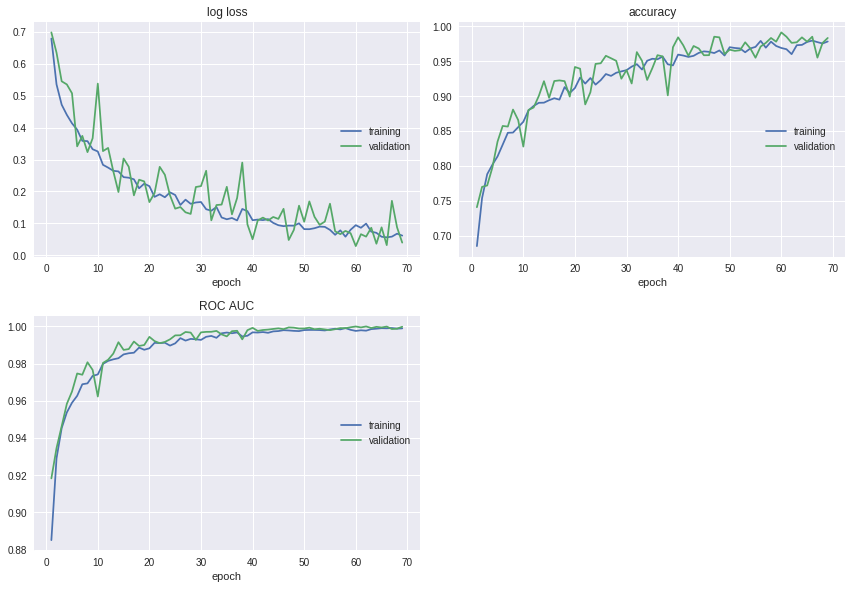


Epoch 70/100 - KFold 5/5


log loss:
training   (min:    0.057, max:    0.679, cur:    0.062)
validation (min:    0.029, max:    0.698, cur:    0.040)

accuracy:
training   (min:    0.685, max:    0.979, cur:    0.978)
validation (min:    0.741, max:    0.991, cur:    0.983)

ROC AUC:
training   (min:    0.885, max:    0.999, cur:    0.999)
validation (min:    0.918, max:    1.000, cur:    1.000)


Items processed: {'melanoma': 1510, 'nevus': 1510, 'seborrheic_keratosis': 1510}
train_loss=0.052, train_acc=0.981, melan_acc=0.979, nevus_acc=0.966, sebor_acc=0.997
Cat 1 ROC AUC: 0.998 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.999


Items processed: {'melanoma': 377, 'nevus': 377, 'seborrheic_keratosis': 377}
valid_loss=0.059, valid_acc=0.984, melan_acc=0.958, nevus_acc=0.995, sebor_acc=1.000
Cat 1 ROC AUC: 0.999 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 1.000


Buffered data was truncated after reaching the output size limit.

In [0]:
model, image_size = initialize_model('densenet', len(classes), use_pretrained=True)

# Freeze denseblock1 and denseblock2
# Train  denseblock3 and denseblock4
set_parameter_requires_grad(itertools.chain(model.features.denseblock3.parameters(), 
                                            model.features.denseblock4.parameters()), feature_extract=False)

optimizer = optim.Adam(get_params_to_optimize(model).values(), lr=0.001, weight_decay=1e-6)

dr_densenet_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

While validation metrics are excellent after 70 epochs, test metrics have more variations ! It overfits to the training/validation set. So I did not keep the very last model. But one of the previous.  

I should also mention that, in the run above, I did not add too much blur, noise and color jitter in train transforms. Hence the validation metrics that reach 1.000 ROC AUC and 99.1% accuracy.  

I kept these (nice) plots because it was one of my longest runs, but the model I kept is from a shorter run, with the data augmentation defined earlier in this book.

# Evaluate the Model

Inspired by the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), the algorithm is ranked according to three separate categories:
- Category 1: ROC AUC for Melanoma Classification
- Category 2: ROC AUC for Melanocytic Classification
- Category 3: Mean ROC AUC

The test_model function below calculates the test Mean ROC AUC of the model on the test set.  
It also returns a data frame with the probabilities of detection of melanoma and seborrheic keratoses in the given images.

In [0]:
def test_model(dirs, model, criterion, resize=0.75):
  
  data_loader = get_test_loader(model.__class__.__name__, resize=resize)
  
  if len(logging.getLogger().handlers)==1:
    init_log('test')
                         
  _, best_auc, _, running_corrects, items_processed, data = epoch_run('test', data_loader, model, criterion)            

  file_names = file_names = [fn.replace(d,'') 
            for d in sorted(dirs) 
            for fn in sorted(glob.glob(os.path.join(d, '*', '*.jpg')))]

  return pd.DataFrame(index=file_names[0:sum(items_processed.values())], data=data, columns=classes), running_corrects, items_processed, best_auc

In [0]:
def get_test_loader(model_name, original_image=False, resize=0.75):
  
  test_image_folder = get_dataset(get_transform(model_name, 'test', resize), [(data_dir['test'] + ('' if original_image else '_resized'))])
  
  return torch.utils.data.DataLoader(test_image_folder, batch_size=batch_size['test'], num_workers=num_workers, shuffle=False)

I need to download the ground_truth.csv where true labels are stored for melanoma and seborrheic keratoses.

In [0]:
!wget -O ground_truth.csv https://raw.githubusercontent.com/sebastienlange/dermatologist-ai/master/ground_truth.csv

In [0]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true
  
y_true = get_ground_truth()

Let's load my trained DenseNet model and name it __Dr DenseNet model__ 😉

In [0]:
def load_model(state_dict_fn):
  
  if os.path.exists(os.path.join(os.getcwd(), state_dict_fn)):
    # already downloaded
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
  elif os.path.exists(os.path.join(google_drive_shared_path, state_dict_fn)):
    # available on my own google drive
    state_dict_fn = os.path.join(google_drive_shared_path, state_dict_fn)
  else:
    state_dict_fn = os.path.join(os.getcwd(), state_dict_fn)
    download_file(state_dict_fn)
  
  model_name = state_dict_fn.split(os.path.sep)[-1].split('_')[0].split('.')[0].lower()
  model, image_size = initialize_model(model_name, len(classes))
  model.load_state_dict(torch.load(state_dict_fn))
  
  return model

In [0]:
dr_densenet_model = load_model('DenseNet.pt')

Now we are ready to __evaluate Dr DenseNet Model__, plot __ROC AUC__ and see how it performs!

In [0]:
# test it
predictions, _, _, _ = test_model(phase_data_dirs['test'], dr_densenet_model, criterion)
subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])

# plot ROC AUC
_ = get_roc_auc(y_true, subset_predictions, plot=True)

__0.909__! Well done!!!  

__Dr. DenseNet__ is an excellent Doctor, with excellent results!  If he had participated in the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), he __would have reached the TOP 3!__

But it's still a human and sometimes he makes mistakes. As I am a rather anxious person, I would prefer to __ask for a second medical opinion__... (My fifth mistake was to be too confident in one single doctor 😉)



# Go Further

## Second Medical Opinion

So let's seek for a second medical opinion from __Dr. [Inception v3](https://arxiv.org/abs/1512.00567)__.  

Note that I again need to specify the layers I want to freeze and the ones I want to train. I choose to freeze until layer named Mixed_4.

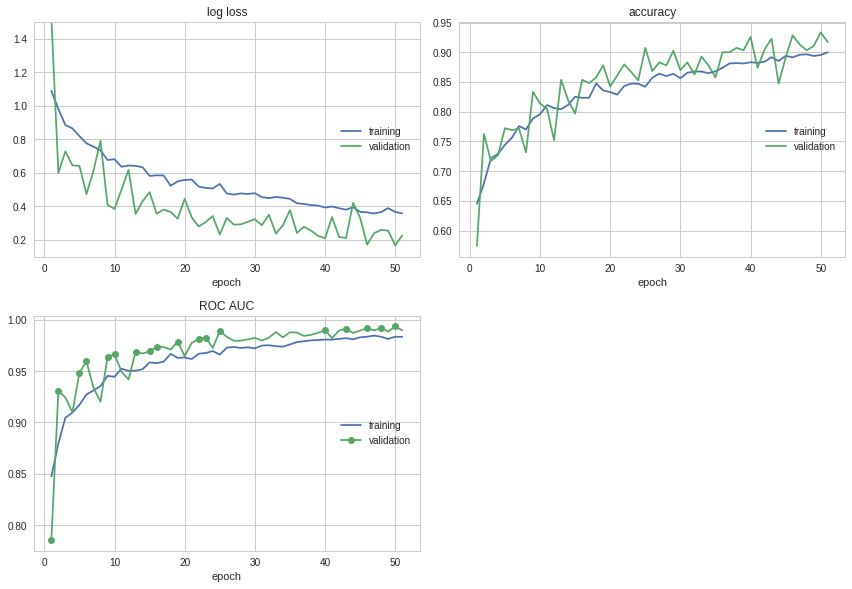


Epoch 52/100 - KFold 2/5


log loss:
training   (min:    0.358, max:    1.088, cur:    0.359)
validation (min:    0.168, max:    1.525, cur:    0.227)

accuracy:
training   (min:    0.645, max:    0.900, cur:    0.900)
validation (min:    0.574, max:    0.933, cur:    0.917)

ROC AUC:
training   (min:    0.848, max:    0.985, cur:    0.983)
validation (min:    0.786, max:    0.993, cur:    0.990)


Training interrupted
End training Inception3 model
Training complete in 288m 27s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  271 parameters to train:
    Mixed_5b.branch1x1.conv.weight
    Mixed_5b.branch1x1.bn.weight
    Mixed_5b.branch1x1.bn.bias
    Mixed_5b.branch5x5_1.conv.weight
    Mixed_5b.branch5x5_1.bn.weight
    ...
    Mixed_7c.branch_pool.conv.weight
    Mixed_7c.branch_pool.bn.weight
    Mixed_7c.branch_pool.bn.bias
    fc.weight
    fc.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(299, 299), scale=(0.7, 1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomAffine(degrees=(-30, 30), trans

In [0]:
model, image_size = initialize_model('inception3', len(classes), use_pretrained=True)

# Freeze Mixed 1 -> 4 layers
# Train  Mixed 5 -> 7 layers
layers_to_train = [f'Mixed_{layer}' for layer in '5b,5c,5d,6a,6b,6c,6d,6e,7a,7b,7c'.split(',')]
set_parameter_requires_grad(itertools.chain.from_iterable([getattr(model, layer).parameters() for layer in layers_to_train]), feature_extract=False)

optimizer = optim.Adam(get_params_to_optimize(model).values(), lr=0.001, weight_decay=1e-6)

dr_inception_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

In [0]:
# load my trained inception model and let's name it Dr Inception model ;-)
dr_inception_model = load_model('Inception3.pt')

In [0]:
predictions, _, _, _ = test_model(phase_data_dirs['test'], dr_inception_model, criterion)
subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])
_ = get_roc_auc(y_true, subset_predictions, plot=True)

TOP 5 for Dr Inception!

## Third Medical Opinion

I now have two medical opinions! Great! But __Dr. DenseNet and Dr. Inception sometimes gives me opposite opinion!__  
So let's look for a third medical opinion that will be able to decide: __Dr. [NASNetALarge](https://github.com/Cadene/pretrained-models.pytorch#nasnet) arrives on stage!__  

Again I need to specify the layers I want to freeze and the ones I want to train. I choose to freeze until layer named cell_8.

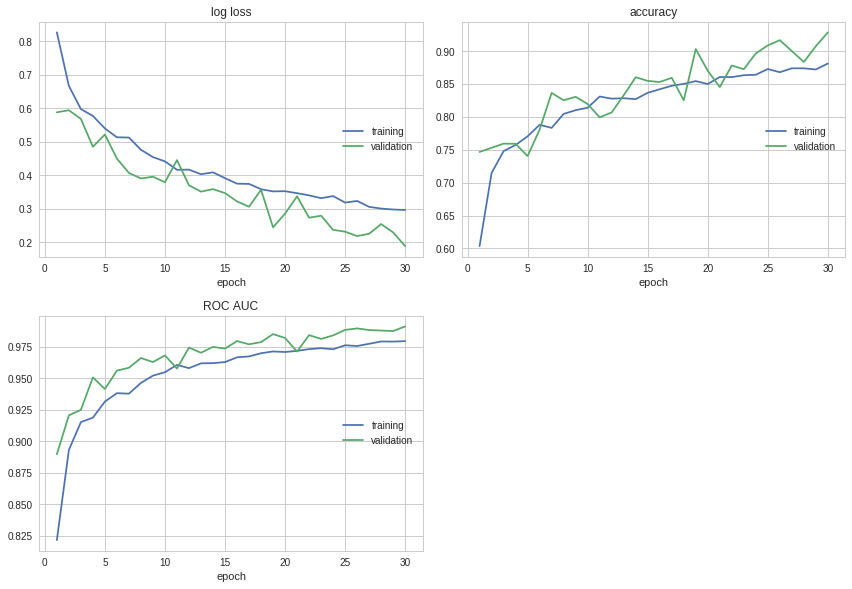


Epoch 31/100 - KFold 1/5


log loss:
training   (min:    0.296, max:    0.826, cur:    0.296)
validation (min:    0.188, max:    0.594, cur:    0.188)

accuracy:
training   (min:    0.603, max:    0.881, cur:    0.881)
validation (min:    0.740, max:    0.928, cur:    0.928)

ROC AUC:
training   (min:    0.821, max:    0.979, cur:    0.979)
validation (min:    0.890, max:    0.991, cur:    0.991)


Training interrupted
End training NASNetALarge model
Training complete in 566m 16s
  Class distribution (4551): 1887 melanoma, 2336 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  371 parameters to train:
    cell_9.conv_prev_1x1.conv.weight
    cell_9.conv_prev_1x1.bn.weight
    cell_9.conv_prev_1x1.bn.bias
    cell_9.conv_1x1.conv.weight
    cell_9.conv_1x1.bn.weight
    ...
    cell_16.comb_iter_4_left.separable_2.pointwise_conv2d.weight
    cell_16.comb_iter_4_left.bn_sep_2.weight
    cell_16.comb_iter_4_left.bn_sep_2.bias
    last_linear.weight
    last_linear.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(331, 331), scale=(0.7, 1), ratio=(0.75, 1.3333), interpolati

In [115]:
model, image_size = initialize_model('nasnetalarge', len(classes), use_pretrained=True)

# Freeze cell_1 -> cell_8
# Train  cell_9 -> cell_17
set_parameter_requires_grad(itertools.chain.from_iterable([getattr(model, f'cell_{i}').parameters() for i in np.arange(9,17)]), feature_extract=False)

optimizer = optim.Adam(get_params_to_optimize(model).values(), lr=0.001, weight_decay=1e-6)

# reduce train batch size because the model requires much more GPU memory
batch_size['train']=16

dr_nasnetlarge_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

In [0]:
# load my trained NASNetALarge model and let's call it Dr NasNetALarge model ;-)
dr_nasnetlarge_model = load_model('NASNetALarge.pt')

In [0]:
predictions, _, _, _ = test_model(phase_data_dirs['test'], dr_nasnetlarge_model, criterion)
subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])
_ = get_roc_auc(y_true, subset_predictions, plot=True)

And TOP 4 for Dr NasNetALarge!

## Committee of Doctors

I'm lucky enough to bring together my three doctors in a committee! Alone, they all fit in the top 5! What a dream team!

They share their results, debate, and __Dr. Inception comes to suggest looking at the dermatoscopic images from different perspectives__.  

He suggest scaling to the following values:

In [0]:
scales = [0.7, 0.75, 0.8, 0.85]

In [0]:
def test_model_with(dirs, scales, model, criterion, original_images):
  # test model once per given scale
  
  all_predictions = {}
  
  for resize in scales:
    print(f'\nTesting {model.__class__.__name__} with resize /{resize}')
    predictions, corrects, items_processed, best_auc = test_model(dirs, model, criterion, resize)
    all_predictions[resize] = (predictions, corrects, items_processed, best_auc)
    
  return all_predictions

Let's create some functions to display individual results:

In [0]:
def get_summary_row(test_result, scale, model):
  
  corrects = test_result[1].values()
  items_processed = test_result[2].values()
  
  return [f'Dr. {model.__class__.__name__}', 
          scale, 
          np.round(sum(corrects)/sum(items_processed), 3), 
          np.round(test_result[3], 3)]
  

In [0]:
def append_summary_row(summary, new_row, background=''):
  
  return summary.append({'Model': f'<b>{new_row[0]}</b>', 
                'Resize':f'{new_row[1]:.3f}', 
                'Accuracy': '<b{0}>{1:.3f}</b>'.format(background, new_row[2]),
                'Cat 3 ROC AUC': '<b{0}>{1:.3f}</b>'.format(background, new_row[3])
                         }, ignore_index=True)

In [0]:
def create_summary(predictions, trained_models, scales):
  
  data = [get_summary_row(predictions[model_idx][scale], scale, trained_models[model_idx]) for scale in scales for model_idx in range(len(trained_models))]
  summary = pd.DataFrame(data=data, columns=['Model', 'Resize', 'Accuracy', 'Cat 3 ROC AUC'])
  summary = append_summary_row(summary, ['Mean', summary['Resize'].mean(), summary['Accuracy'].mean(), summary['Cat 3 ROC AUC'].mean()])
  
  return summary

Now I load my three models, and test them with choosen scales:

In [0]:
trained_models = [load_model(fn) for fn in ['NASNetALarge.pt', 'DenseNet.pt', 'Inception3.pt']]

In [0]:
# test all models with given scales
predictions = {i:test_model_with(phase_data_dirs['test'], scales, model, criterion, False) for i, model in enumerate(trained_models)}


Testing NASNetALarge with resize /0.7


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.667, test_acc=0.748, melan_acc=0.650, nevus_acc=0.758, sebor_acc=0.833
Cat 1 ROC AUC: 0.852 Cat 2 ROC AUC: 0.938 Cat 3 ROC AUC: 0.895



Testing NASNetALarge with resize /0.75


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.657, test_acc=0.762, melan_acc=0.650, nevus_acc=0.779, sebor_acc=0.833
Cat 1 ROC AUC: 0.847 Cat 2 ROC AUC: 0.948 Cat 3 ROC AUC: 0.898



Testing NASNetALarge with resize /0.8


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.652, test_acc=0.753, melan_acc=0.667, nevus_acc=0.758, sebor_acc=0.844
Cat 1 ROC AUC: 0.831 Cat 2 ROC AUC: 0.950 Cat 3 ROC AUC: 0.891



Testing NASNetALarge with resize /0.85


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.639, test_acc=0.757, melan_acc=0.641, nevus_acc=0.763, sebor_acc=0.878
Cat 1 ROC AUC: 0.846 Cat 2 ROC AUC: 0.953 Cat 3 ROC AUC: 0.899



Testing DenseNet with resize /0.7


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=1.083, test_acc=0.745, melan_acc=0.761, nevus_acc=0.748, sebor_acc=0.711
Cat 1 ROC AUC: 0.871 Cat 2 ROC AUC: 0.951 Cat 3 ROC AUC: 0.911



Testing DenseNet with resize /0.75


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=1.107, test_acc=0.750, melan_acc=0.769, nevus_acc=0.738, sebor_acc=0.778
Cat 1 ROC AUC: 0.866 Cat 2 ROC AUC: 0.951 Cat 3 ROC AUC: 0.909



Testing DenseNet with resize /0.8


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=1.082, test_acc=0.737, melan_acc=0.752, nevus_acc=0.735, sebor_acc=0.722
Cat 1 ROC AUC: 0.862 Cat 2 ROC AUC: 0.951 Cat 3 ROC AUC: 0.906



Testing DenseNet with resize /0.85


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=1.079, test_acc=0.743, melan_acc=0.744, nevus_acc=0.735, sebor_acc=0.778
Cat 1 ROC AUC: 0.862 Cat 2 ROC AUC: 0.957 Cat 3 ROC AUC: 0.909



Testing Inception3 with resize /0.7


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.726, test_acc=0.763, melan_acc=0.573, nevus_acc=0.860, sebor_acc=0.589
Cat 1 ROC AUC: 0.857 Cat 2 ROC AUC: 0.929 Cat 3 ROC AUC: 0.893



Testing Inception3 with resize /0.75


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.735, test_acc=0.752, melan_acc=0.521, nevus_acc=0.855, sebor_acc=0.600
Cat 1 ROC AUC: 0.852 Cat 2 ROC AUC: 0.933 Cat 3 ROC AUC: 0.892



Testing Inception3 with resize /0.8


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.710, test_acc=0.753, melan_acc=0.521, nevus_acc=0.855, sebor_acc=0.611
Cat 1 ROC AUC: 0.853 Cat 2 ROC AUC: 0.937 Cat 3 ROC AUC: 0.895



Testing Inception3 with resize /0.85


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=0.739, test_acc=0.748, melan_acc=0.487, nevus_acc=0.863, sebor_acc=0.589
Cat 1 ROC AUC: 0.847 Cat 2 ROC AUC: 0.938 Cat 3 ROC AUC: 0.893


Here are their results at different perspectives:

In [0]:
from IPython.display import HTML

summary = create_summary(predictions, trained_models, scales)

HTML(summary.to_html(escape=False))

,Model,Resize,Accuracy,Cat 3 ROC AUC
0,Dr. NASNetALarge,0.7,0.748,0
1,Dr. DenseNet,0.7,0.745,0
2,Dr. Inception3,0.7,0.763,0
3,Dr. NASNetALarge,0.75,0.762,0
4,Dr. DenseNet,0.75,0.75,0
5,Dr. Inception3,0.75,0.752,0
6,Dr. NASNetALarge,0.8,0.753,0
7,Dr. DenseNet,0.8,0.737,0
8,Dr. Inception3,0.8,0.753,0
9,Dr. NASNetALarge,0.85,0.757,0


So their individual Cat 3 ROC AUC range from 0.891 to 0.911 with a 0.899 mean.

### Final scores

My sixth mistake was to try immediately to give a different weight to my prefered Dr. (and most trained) and yet different weights to the scales 😉. I even tried with [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html) to train another model on top on my 12\*3 features (12 different test runs and 3 probabilities as output; only two are useful as the thrid is one minus the others)

Giving it a try is not a mistake! It's to start with a complex algorithm that makes the mistake.

There is a very __simple algorithm to try here__: let's give equal value to each perspective and extract for each image the __mean of all probabilities__:


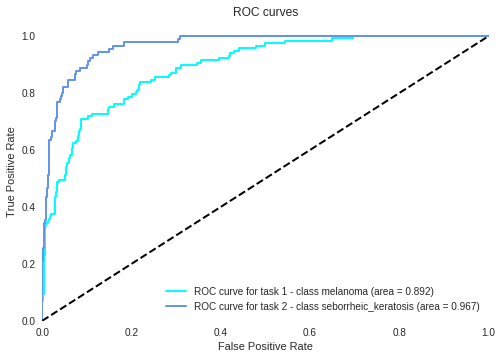

Category 1 Score: 0.892
Category 2 Score: 0.967
Category 3 Score: 0.929


,Model,Resize,Accuracy,Cat 3 ROC AUC
0,Dr. NASNetALarge,0.7,0.748,0
1,Dr. DenseNet,0.7,0.745,0
2,Dr. Inception3,0.7,0.763,0
3,Dr. NASNetALarge,0.75,0.762,0
4,Dr. DenseNet,0.75,0.75,0
5,Dr. Inception3,0.75,0.752,0
6,Dr. NASNetALarge,0.8,0.753,0
7,Dr. DenseNet,0.8,0.737,0
8,Dr. Inception3,0.8,0.753,0
9,Dr. NASNetALarge,0.85,0.757,0


In [0]:
predictions_by_model = {(model_idx, scale): predictions[model_idx][scale][0].as_matrix(columns=[classes[0], classes[1], classes[2]]) 
                        for scale in scales for model_idx in range(len(trained_models))}

y = get_true_labels(phase_data_dirs['test'])
   
# for every image, I calculate the mean probability of my 16 test runs
mean_predictions = np.mean(list(predictions_by_model.values()), axis=0)

# plot ROC AUC
best_auc = get_roc_auc(y_true, mean_predictions[:, [0,2]], plot=True)

summary = append_summary_row(summary, ['Committee of Doctors', 
                               np.NaN, 
                               sum(y == np.argmax(mean_predictions, axis=1))/mean_predictions.shape[0],
                               best_auc[2]], ' style="background-color: yellow"')

HTML(summary.to_html(escape=False))

Wow!  Great!  

__ROC AUC Mean score climbs to 0.929 and outperforms the first score of the initial challenge!__

Editor's note: before giving a try to multiple models, I had initially written in my conclusions: *"I only tried DenseNet with all parameters freezed! I'm pretty sure that a combination of Resnet / Inception / VGG / DenseNet with some re-trained layers and a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier. html) would push the limits higher!"*. And I was right! 😃😃😃

# Conclusions

I was able to achieve a __Mean ROC AUC score of 0.929__. It would have been a __TOP 1__ in the initial challenge (see scores below). It's very satisfying for what I wanted to achieve, especially since the __winner's score is 0.911__.  😃

But much more than this score, I learned a lot and sometimes the hard way, and took a lot of fun. 😅

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/cat_3.png?raw=1)

## Possible points of improvement
Here are possible points of improvement to reach better results:
- test loss is much higher than training/validation loss; although it was not the measure observed during the challenge, I observed it and felt that it was showing too much overfitting to the training/validation set (same for accuracy but to a lesser extent) 
- more or different __data augmentations__ techniques. Particularly, I integrated [imgaug](https://github.com/aleju/imgaug) lately, so there's __a lot to try with [imgaug](https://github.com/aleju/imgaug)__! Particularly add more noise in image (like improved fake hairs, patch and add fake ruler)
- I chose to divide more or less in two equal parts the number of frozen and trained layers. So, __I'm pretty sure there's a better point than "randomly" choosing first half of layers as frozen and second half as trained layers__
- use different source of images : all the images come from the same distribution
- try [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) with my three models
- give more chance to other transfer learning models, and particularly try different parameters: I spent most on my time with DenseNet and I kept the same parameters for others while it could be adapted for each of them...
- fine tune learning rate and other optimizer hyper parameters to speed up gradient descent (Adam with lr 0.002 often worked with earlier versions of the model)
- __detect the area of interest for each image and zoom in on it__.
- give a try to other optimizers: AdaGrad, RMSProp, Adamax, Adadelta...
- try different batch_size to see how it impacts training (the final model reachs a GPU out of memory with a batch size of 64 [Google colab GPU])
- display images where the model fails to understand why it fails and maybe improve algorithm, data augmentation...

## XGBClassifier

I keep my trial with XGBClassifier here for my own reference. As the code it uses has changed, it may not run correctly anymore.

In [0]:
def get_features(dirs, trained_models, criterion):
  
  dataset = ConcatDataset([datasets.ImageFolder(d + '_resized', transform=get_transform('densenet', 'test')) for d in dirs])
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size['train'], num_workers=num_workers)
  
  X = {}
  
  
  for model in trained_models:
    predictions, _, _ = test_model(data_loader, dirs, model, criterion)
    X[model.__class__.__name__] = predictions.as_matrix(columns=[classes[0], classes[1], classes[2]])
  
  return X

In [0]:
X_dict = get_features(phase_data_dirs['train'], trained_models, criterion)

X = np.empty((len(y),0))
for x in X_dict.values():
  X = np.append(X, x, axis=1)  

In [0]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

n_estimators = [150,200,250,300]
learning_rates = [0.04, 0.03, 0.02]
max_depth = [2, 3]
reg_lambda = [0.50]

param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rates, 'max_depth': max_depth, 'reg_lambda': reg_lambda}
  
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

xgb_clf = xgb.XGBClassifier()

gs = GridSearchCV(xgb_clf, param_grid, refit=True, cv=cv, scoring='accuracy', verbose=3, n_jobs=-1)
gs.fit(X, y)

print(f'Best Params: {gs.best_params_}')
print(f'Best Score:  {gs.best_score_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


Best Params: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 250, 'reg_lambda': 0.5}
Best Score:  0.9749120750293083


In [0]:
X_test = np.append(np.append(predictions[0][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), 
                   predictions[1][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), axis=1),
                   predictions[2][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), axis=1)


In [0]:
y_pred = gs.best_estimator_.predict_proba(X_test)
y_true = get_ground_truth()

plot_roc_auc(y_true, y_pred[:,[0,2]])